### GANs - Generative Adversarial Networks

Previous example: [/examples/autoencoders/vae.ipynb](https://github.com/serhatsoyer/py4ML/blob/main/examples/autoencoders/vae.ipynb)  
Modified from: [GAN section of Tensorflow Udemy Course from Jose Portilla - Pierian Training](https://www.udemy.com/course/complete-tensorflow-2-and-keras-deep-learning-bootcamp/)  
Next example: [/examples/autoencoders/lstm.ipynb](https://github.com/serhatsoyer/py4ML/blob/main/examples/autoencoders/lstm.ipynb)

In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Reshape, BatchNormalization, Conv2DTranspose, LeakyReLU, Conv2D, Flatten
import tensorflow as tf

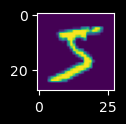

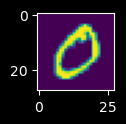

x_train.min() = -1.0
x_train.max() = 1.0


In [2]:
(x_train, y_train), (_, _) = mnist.load_data()
plt.style.use('dark_background')
plt.figure(figsize=(1, 1))
plt.imshow(x_train[0])
plt.show()
x_train = x_train[y_train==0]
plt.figure(figsize=(1, 1))
plt.imshow(x_train[0])
plt.show()
x_train = x_train / 255
x_train = x_train.reshape(-1, 28, 28, 1) * 2 - 1 # To make it look like 'tanh'
print(f'{x_train.min() = }')
print(f'{x_train.max() = }')

In [3]:
generator = Sequential()
code_size = 32
generator.add(Dense(7 * 7 * 128, input_shape=[code_size]))
generator.add(Dropout(0.5))
generator.add(Reshape([7, 7, 128]))
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh'))

discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(0.3), input_shape=[28, 28, 1]))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(0.3)))
discriminator.add(Flatten())
discriminator.add(Dense(64, activation='relu'))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(32, activation='relu'))
discriminator.add(Dense(1, activation='sigmoid')) # Is this image real or fake
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

GAN = Sequential([generator, discriminator])
discriminator.trainable = False
GAN.compile(loss='binary_crossentropy', optimizer='adam')

print(f'{generator.trainable = }')
print(f'{discriminator.trainable = }')
print(f'{GAN.trainable = }')
print(f'{GAN.layers[0].trainable = }')
print(f'{GAN.layers[1].trainable = }')

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

generator.trainable = True
discriminator.trainable = False
GAN.trainable = True
GAN.layers[0].trainable = True
GAN.layers[1].trainable = False


2023-01-03 14:28:59.912090: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-03 14:28:59.912193: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              206976    
                                                                 
 dropout (Dropout)           (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       204864    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 1)        1

In [5]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                401472    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                

In [6]:
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         413697    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 610177    
                                                                 
Total params: 1,023,874
Trainable params: 413,569
Non-trainable params: 610,305
_________________________________________________________________


In [7]:
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size=1000)
print(f'{type(dataset) = }')
batch_size = 128
dataset = dataset.batch(batch_size, drop_remainder=True)
print(f'{type(dataset) = }')

type(dataset) = <class 'tensorflow.python.data.ops.dataset_ops.ShuffleDataset'>
type(dataset) = <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [8]:
for epoch in range(16): # Number of epochs
    print(f'Epoch #{epoch + 1}')
    for x_batch in dataset:
        gen_images = generator(tf.random.normal(shape=[batch_size, code_size]))
        x_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(x_batch, tf.float32)], axis=0)
        y_fake_vs_real = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        discriminator.trainable = True
        discriminator.train_on_batch(x_fake_vs_real, y_fake_vs_real)
        discriminator.trainable = False
        GAN.train_on_batch(tf.random.normal(shape=[batch_size, code_size]), tf.constant([[1.]] * batch_size))
        # Even if the input is random, try to fool the discriminator by labeling the input as 1

Epoch #1


2023-01-03 14:29:00.493233: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-03 14:29:00.493545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-03 14:29:00.915356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch #2
Epoch #3
Epoch #4
Epoch #5
Epoch #6
Epoch #7
Epoch #8
Epoch #9
Epoch #10
Epoch #11
Epoch #12
Epoch #13
Epoch #14
Epoch #15
Epoch #16


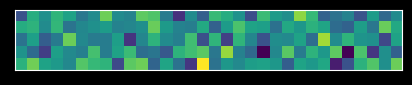

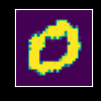

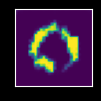

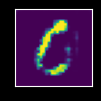

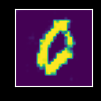

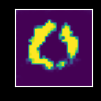

In [9]:
num_of_images = 5
noise = tf.random.normal(shape=[num_of_images, code_size])
noise.shape
plt.figure(figsize=(num_of_images, 1))
plt.xticks([], [])
plt.yticks([], [])
plt.imshow(noise)
plt.show()
image = generator(noise)
for idx in range(num_of_images):
    plt.figure(figsize=(1, 1))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(image[idx])
    plt.show()

Previous example: [/examples/autoencoders/vae.ipynb](https://github.com/serhatsoyer/py4ML/blob/main/examples/autoencoders/vae.ipynb)  
Modified from: [GAN section of Tensorflow Udemy Course from Jose Portilla - Pierian Training](https://www.udemy.com/course/complete-tensorflow-2-and-keras-deep-learning-bootcamp/)  
Next example: [/examples/autoencoders/lstm.ipynb](https://github.com/serhatsoyer/py4ML/blob/main/examples/autoencoders/lstm.ipynb)